# General data reader for AQUA 

AQUA is built on different python classes, the `Reader` one being the cornerstone in order to provide a centralized common data access point in order to develop diagnostics. 

AQUA `Reader` uses `intake` catalogues from NextGEMS data, plus other observational datasets. It has been tested and developed on Levante, but it is has been tested also on MN4 and Lumi. An FDB direct access is currently developed, being transparent to the users.

On top of data access, the `Reader` includes also other functionalities: regridding, time and spatial averaging and metadata correction. Since streaming is not yet available, a streaming emulator has been introduced and can used to mimic streaming.

All these features can be used by the frontier diagnostics when they get real time data. Alternatively, some data have been included in the *Low Resolution Archive* (LRA), which is being built for each experiments and includes variable on monthly frequency, coarse grid and common metadata. State-of-the-art diagnostics can build on the LRA directly.

The idea of the regridder (which uses sparse matrix multiplication) is to generate first the weights for the interpolation (an operation which needs to be done only once) and then to use them for each regridding operation. For regridding to work you will need the external [smmregrid](https://github.com/jhardenberg/smmregrid) module in your environment.

The following notebooks illustrate more in detail different aspects of the functionality of the reader:

1. [Regridding](regrid.ipynb)
2. [Coordinate, variable name, units fixer](fixer.ipynb)
2. [Temporal averaging](timmean.ipynb)
3. [Spatial (field) averaging](fldmean.ipynb)
4. [Other datasets](datasets.ipynb)
5. [Streaming](streaming.ipynb)
6. [Accessor](accessor.ipynb)

## Basic functionality

In a nutshell, how to load ICON data, regrid them to a regular grid and plot a timeseries.

We start loading the module:

In [1]:
from aqua import Reader

Now let's load some EN4 data. 

We first instantiate a `Reader` object specifying the type of data which we want to read from the catalogue. The `Reader` access is build on a 3-level hierarchy, made of `model`, `exp` and `source`. 

We also specify that we would like to regrid to a 0.1°x0.1° grid (`r100` for AQUA syntax). The first time (only then) when you run it, it will compute regridding weights for this particular source/destination grid combination. These will be stored in a directory specified in the `config/machines/<machine_name>/catalog.yaml` file. In this notebook we worked on levante, so the weights will be stored in `config/machines/levante/catalog.yaml`.

In [2]:
reader = Reader(model="EN4", exp="en4", source="monthly", regrid='r100', fix=False)

Later  the actual data can be read with the `retrieve` method. We have kept `fix=False` to access the data as they are. Please note that default is `fix=True`.

In [3]:
data = reader.retrieve()

The reader returns an `xarray.Dataset` with raw EN4 data on the original grid.

In [4]:
data

<xarray.Dataset>
Dimensions:             (time: 876, bnds: 2, lon: 360, lat: 180, lev: 42)
Coordinates:
  * time                (time) datetime64[ns] 1950-01-16T12:00:00 ... 2022-12...
  * lon                 (lon) float64 1.0 2.0 3.0 4.0 ... 358.0 359.0 360.0
  * lat                 (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * lev                 (lev) float32 5.022 15.08 25.16 ... 5.051e+03 5.35e+03
    idx_lev             (lev) int64 0 1 2 3 4 5 6 7 ... 34 35 36 37 38 39 40 41
Dimensions without coordinates: bnds
Data variables:
    time_bnds           (time, bnds) datetime64[ns] dask.array<chunksize=(12, 2), meta=np.ndarray>
    lon_bnds            (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    lat_bnds            (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lev_bnds            (lev, bnds) float32 dask.array<chunksize=(42, 2), meta=np.ndarray>
    so                  (time, lev, lat, lon) float32 dask.array<chunksize=(12, 1, 180, 360), meta=np.ndarray>
    so_uncertainty      (time, lev, lat, lon) float32 dask.array<chunksize=(12, 1, 180, 360), meta=np.ndarray>
    thetao              (time, lev, lat, lon) float32 dask.array<chunksize=(12, 1, 180, 360), meta=np.ndarray>
    thetao_uncertainty  (time, lev, lat, lon) float32 dask.array<chunksize=(12, 1, 180, 360), meta=np.ndarray>
Attributes: (12/25)
    CDI:                    Climate Data Interface version 2.0.5 (https://mpi...
    Conventions:            CF-1.0
    institution:            UK Met Office
    title:                  Temperature and salinity analysis
    DSD_entry_id:           UKMO-L4UHFnd-GLOB-v01
    references:             Website and paper: https://www.metoffice.gov.uk/h...
    ...                     ...
    easternmost_longitude:  362.5
    file_quality_index:     0
    licence:                EN4 is distributed under the Non Commercial Gover...
    history:                Thu Jun 29 09:47:09 2023: cdo mergetime so_195001...
    NCO:                    netCDF Operators version 4.9.2 (Homepage = http:/...
    CDO:                    Climate Data Operators version 2.0.5 (https://mpi...

Let's inspect the "so" variable (in a DataArray)

In [5]:
data.so

<xarray.DataArray 'so' (time: 876, lev: 42, lat: 180, lon: 360)>
dask.array<open_dataset-so, shape=(876, 42, 180, 360), dtype=float32, chunksize=(12, 1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1950-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 1.0 2.0 3.0 4.0 5.0 ... 356.0 357.0 358.0 359.0 360.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 86.0 87.0 88.0 89.0
  * lev      (lev) float32 5.022 15.08 25.16 ... 4.752e+03 5.051e+03 5.35e+03
    idx_lev  (lev) int64 0 1 2 3 4 5 6 7 8 9 ... 32 33 34 35 36 37 38 39 40 41
Attributes:
    standard_name:  salinity
    long_name:      Salinity
    units:          0.001

A method to have some information about the reader setup is `info()`

In [6]:
reader.dst_grid_name

'r100'

In [7]:
reader.info()

Reader for model EN4, experiment en4, source monthly
Regridding is active:
  Target grid is r100
  Regridding method is ycon
Metadata:
  source_grid_name: en4
  catalog_dir: /users/nazarova/work/AQUA/config/machines/lumi/catalog/EN4/
  dims: {'time': 876, 'bnds': 2, 'lon': 360, 'lat': 180, 'lev': 42}
  data_vars: {'time_bnds': ['time'], 'lon_bnds': ['lon'], 'lat_bnds': ['lat'], 'lev_bnds': ['lev'], 'so': ['time', 'lon', 'lat', 'lev'], 'so_uncertainty': ['time', 'lon', 'lat', 'lev'], 'thetao': ['time', 'lon', 'lat', 'lev'], 'thetao_uncertainty': ['time', 'lon', 'lat', 'lev']}
  coords: ('time', 'lon', 'lat', 'lev')
  CDI: Climate Data Interface version 2.0.5 (https://mpimet.mpg.de/cdi)
  Conventions: CF-1.0
  institution: UK Met Office
  title: Temperature and salinity analysis
  DSD_entry_id: UKMO-L4UHFnd-GLOB-v01
  references: Website and paper: https://www.metoffice.gov.uk/hadobs/en4/; Good, S. A., M. J. Martin and N. A. Rayner, 2013. EN4: quality controlled ocean temperature and sal

However, one of the possibility of the `Reader` is to have both CERES data on a common data format, namely grib-like, so that we can let `fix=True` and retrieve the data

In [8]:
reader = Reader(model="CERES", exp="ebaf-sfc41", source="monthly", regrid='r100', fix=True)
data = reader.retrieve()

Notice that these data are still on the original (irregular) grid. We can regrid (part of) them with:

In [9]:
msnswrf_r = reader.regrid(data['msnswrf'].isel(time=10))
msnswrf_r

<xarray.DataArray 'msnswrf' (lat: 180, lon: 360)>
dask.array<reshape, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2001-01-15
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes: (12/13)
    standard_name:  Surface Net Shortwave Flux - All-Sky
    long_name:      Mean surface net short-wave radiation flux
    units:          W m-2
    CF_name:        surface_net_downward_shortwave_flux
    comment:        none
    valid_min:            0.00000
    ...             ...
    history:        \n2024-02-15 17:39:18 AQUA💧: Variable msnswrf, derived wi...
    paramId:        235037
    cfVarName:      msnswrf
    shortName:      msnswrf
    derived:        sfc_net_sw_all_mon
    regridded:      1

and finally plot them:

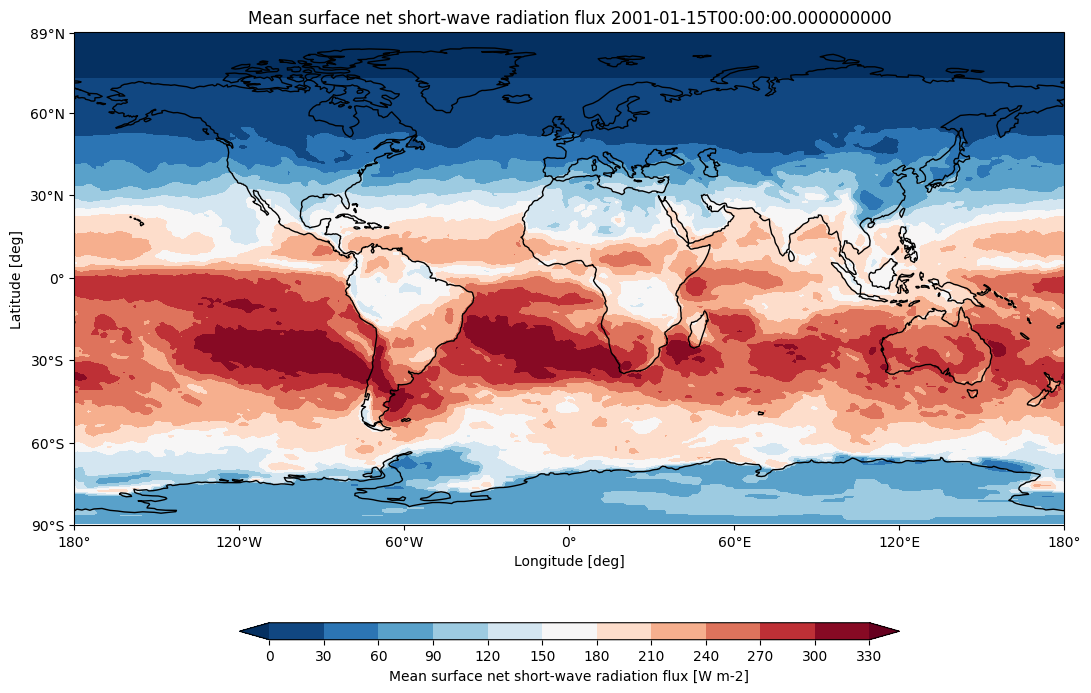

In [10]:
msnswrf_r.aqua.plot_single_map()

We can also plot a timeseries using the `fldmean` method, which performs a spatial average over the whole domain.

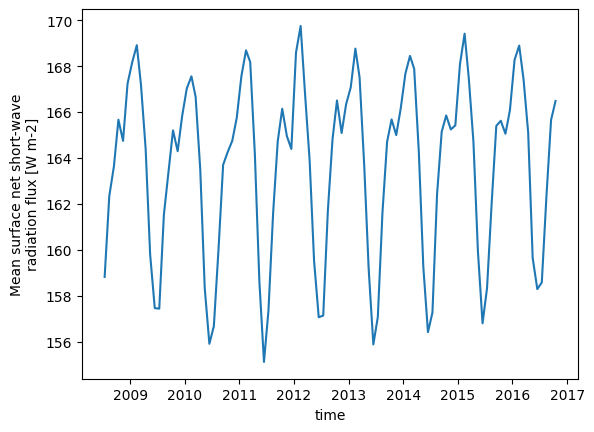

In [11]:
global_mean = reader.fldmean(data['msnswrf'].isel(time=slice(100,200)))
global_mean.plot()

Modifying the `Reader` 3-level hierarchy, we can also access directly data from the LRA, in this case below for WOA18.

In [12]:
reader = Reader(model="WOA18", exp="woa18_2005_2017", source="annual", fix=False)
data = reader.retrieve()
data

<xarray.Dataset>
Dimensions:             (lat: 720, nbounds: 2, lon: 1440, depth: 102, time: 1)
Coordinates:
  * lat                 (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon                 (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
  * depth               (depth) float32 0.0 5.0 10.0 ... 5.3e+03 5.4e+03 5.5e+03
  * time                (time) float32 726.0
    idx_depth           (depth) int64 0 1 2 3 4 5 6 7 ... 95 96 97 98 99 100 101
Dimensions without coordinates: nbounds
Data variables: (12/19)
    crs                 int32 -2147483647
    lat_bnds            (lat, nbounds) float32 dask.array<chunksize=(720, 2), meta=np.ndarray>
    lon_bnds            (lon, nbounds) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
    depth_bnds          (depth, nbounds) float32 dask.array<chunksize=(102, 2), meta=np.ndarray>
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    s_an                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 26, 180, 360), meta=np.ndarray>
    ...                  ...
    t_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 26, 180, 360), meta=np.ndarray>
    t_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 26, 180, 360), meta=np.ndarray>
    t_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 26, 180, 360), meta=np.ndarray>
    t_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 26, 180, 360), meta=np.ndarray>
    t_oa                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 26, 180, 360), meta=np.ndarray>
    t_gp                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 26, 180, 360), meta=np.ndarray>
Attributes: (12/50)
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_salin...
    summary:                         Climatological mean salinity for the glo...
    references:                      Zweng, M. M, J. R. Reagan, D. Seidov, T....
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    ...                              ...
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   https://www.nodc.noaa.gov/OC5/woa18/
    date_created:                    2019-07-29 
    date_modified:                   2019-07-29 
    history:                         \n2024-02-15 17:39:38 AQUA💧: Retrieved f...

We can easily plot the t_an variable:

2024-02-15 17:39:49 :: Check coordinates :: WARNING  -> lon_min and lon_max are the same, setting them to default values


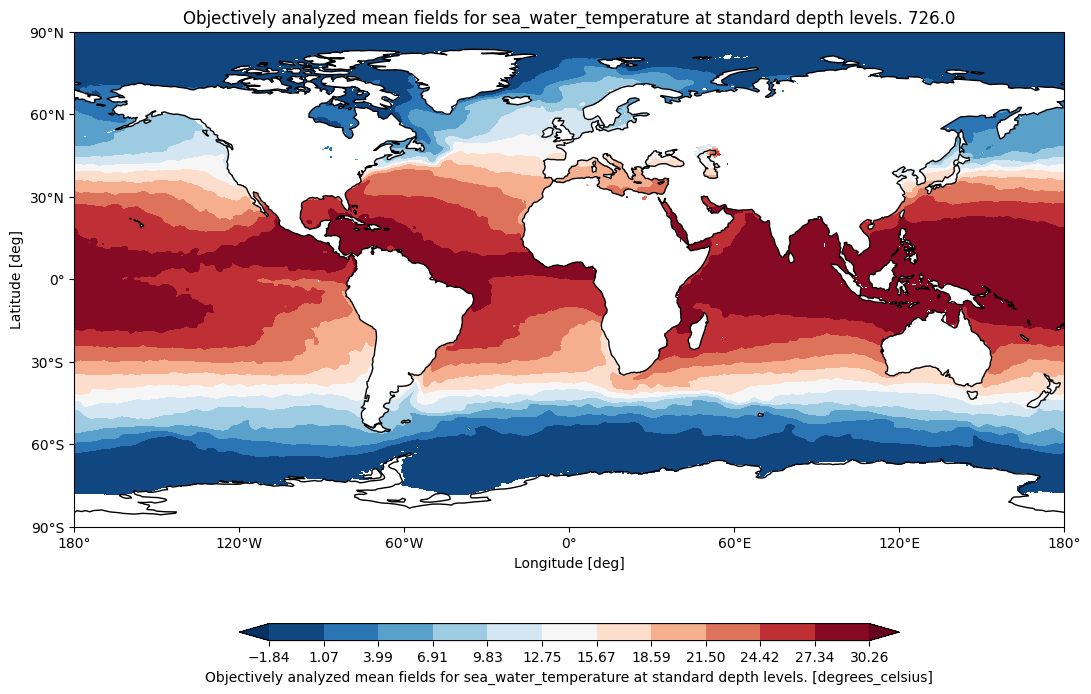

In [13]:
data['t_an'].isel(time=0).isel(depth=0).aqua.plot_single_map()

## Extra notes

### Dask

It is convenient to start a Dask cluster first (unless you already are working on a Levante jupyter hub) and to connect to it

In [14]:
from dask.distributed import LocalCluster, Client
cluster = LocalCluster(ip="0.0.0.0", threads_per_worker=2, n_workers=16)
client = Client(cluster)
cluster

LocalCluster(5433498c, 'tcp://193.167.209.166:45825', workers=16, threads=32, memory=64.00 GiB)

The cluster can then be closed at the end of the notebook with:

In [15]:
cluster.close()

### Catalogue

In order to check what is available in the catalogue there is the `catalogue()` function. It returns the catalogue itself by default, that's why we use it with a semicolon at the end.

In [16]:
from aqua import catalogue
catalogue();

IFS	fdb-tco399	fdb-long data tco399 grid
	- fdb-long-2d	FDB data tco399 grid
	- fdb-long-3d	FDB data tco399 grid

IFS-NEMO	control-1950-dev	FDB IFS/NEMO tco1279-orca025 control 1950 run
	- hourly-native	hourly data on native grid TCo1279 (about 10km). Contains tprate(260048), 2t(167), 10u(165), 10v(166), 100u(228246), 100v(228247), sr(173), blh(159), 2d(168), skt(235), chnk(148). See fix yaml for derived vars.
	- hourly-1deg	hourly data on r100 grid. Contains tprate(260048), sf(144), 2t(167), 10u(165), blh(159), sshf(146), slhf(147), ssrd(169), ssr(176), strd(175), str(177), ttr(179), e(182), tsr(178), ewss(180), nsss(181), chnk(148), sro(8), ssro(9). See fix yaml for derived vars.
	- 6hourly-1deg	6hourly data on r100 grid. Contains z(129).
	- monthly-1deg-2d	monthly data on r100 grid. Contains tcc(164), sd(141), tciw(79), tclw(78), msl(151), tcwv(137), lcc(186), mcc(187), hcc(188).
	- monthly-1deg-3d	monthly data on r100 grid. Contains u(131), v(132), t(130), r(157), q(133).
	- lra-r1

The data are classified in "models" (e.g. ICON, IFS etc.). Each model has a different "experiment" and there are different "sources" for each of them. 

A note on configuration files: by default the reader looks for its config files in this list of folders:

- `$AQUA`
- `./../../AQUA/config`
- `./config`
- `../config`
- `../../config`
- `../../../config`
- `$HOME/.aqua/config`

where `$AQUA` is the environment variable pointing to the AQUA folder if the user has it defined.